<a href="https://colab.research.google.com/github/aashrithresearch/pytorch_pathology/blob/main/lymphoma_validation_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpuid = 0
dataname = 'lymphoma'
patch_size = 224
batch_size = 1
nprint = 2

In [3]:
! pip install tensorboardX -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.0 MB/s eta 0:00:00


In [4]:
import random, sys
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
import time
import tables
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet
import PIL

In [5]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=b33be83b-7beb-f3e9-1d1c-3cc207772200, L2_cache_size=4MB)


In [7]:
checkpoint = torch.load(f"/content/drive/MyDrive/lymphoma.tar/{dataname}_densenet_best_model.pth", weights_only=False)

In [8]:
model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	415683


<All keys matched successfully>

In [9]:
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        self.fname=fname

        self.img_transform=img_transform

        self.tables=tables.open_file(self.fname)
        self.classsizes=self.tables.root.classsizes[:]
        self.nitems=self.tables.root.imgs.shape[0]
        self.tables.close()

        self.imgs = None
        self.labels = None

    def __getitem__(self, index):
        if(self.imgs is None):
            self.tables=tables.open_file(self.fname)
            self.imgs=self.tables.root.imgs
            self.labels=self.tables.root.labels

        img = self.imgs[index,:,:,:]
        label = self.labels[index]

        img_new = img

        if self.img_transform is not None:
            img_new = self.img_transform(img)


        return img_new, label, img
    def __len__(self):
        return self.nitems

In [11]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True),
    transforms.ToTensor()
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases:
    dataset[phase]=Dataset(f"/content/drive/MyDrive/lymphoma.tar/{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size,
                                shuffle=True, num_workers=0, pin_memory=True)

[ 1.0144712 -4.846422  -0.1925776]
True class:		0
Predicted class:	0
--------
[-4.534166  -4.6427684  5.6603203]
True class:		2
Predicted class:	2
--------
[-4.817366   4.938606  -3.0624502]
True class:		1
Predicted class:	1
--------
[-5.098463  -4.3516974  5.8066072]
True class:		2
Predicted class:	2
--------
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]
Accuracy:	1.0


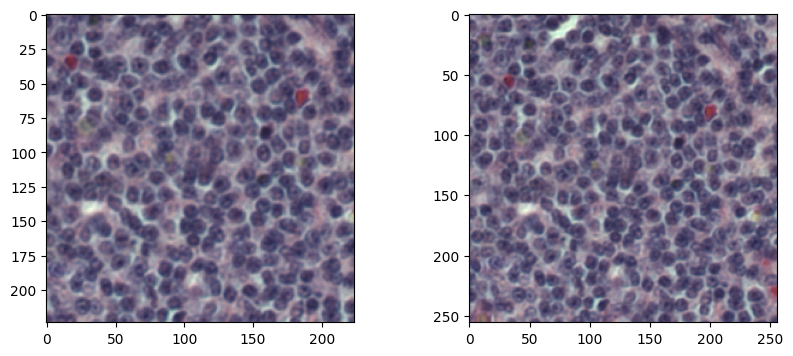

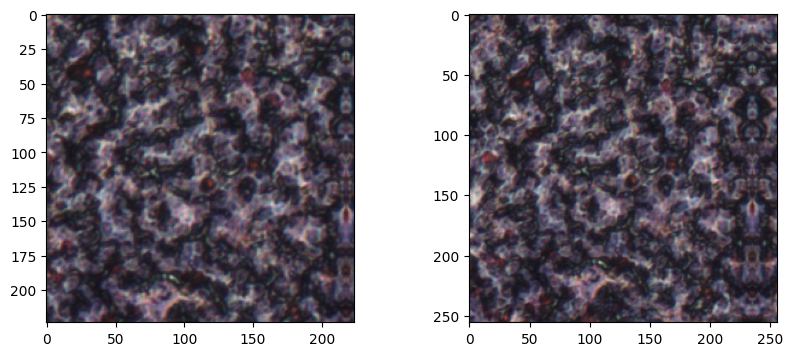

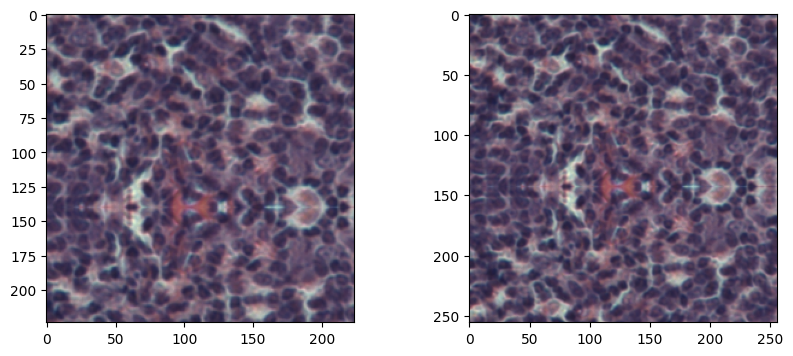

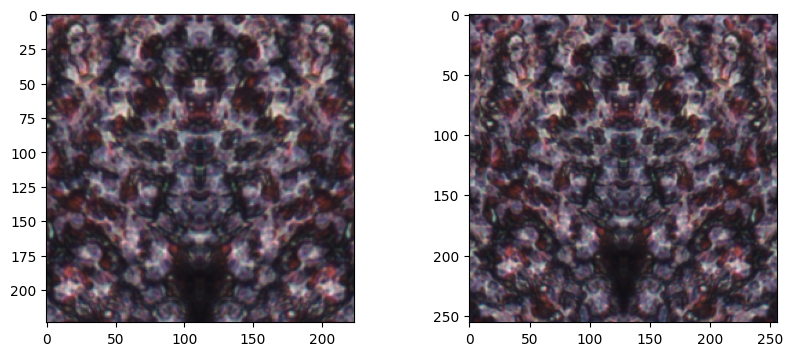

In [13]:
%matplotlib inline

model.eval()
confmatrix=np.zeros((checkpoint["num_classes"],checkpoint["num_classes"]))
for ii , (X, label, img_orig) in enumerate(dataLoader['val']):
    X = X.to(device)
    label = label.type('torch.LongTensor').to(device)

    output = model(X)

    output=output.detach().squeeze().cpu().numpy()

    print(output)
    gt=label.cpu()[0]
    pred=np.argmax(output)
    confmatrix[gt,pred]+=1
    print(f"True class:\t\t{gt}")
    print(f"Predicted class:\t{pred}")
    print("--------")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    ax[1].imshow(img_orig.cpu().squeeze())

    if(ii>nprint):
        break

print(confmatrix)
print(f"Accuracy:\t{confmatrix.trace()/confmatrix.sum()}")